# Рекомендация тарифов

Преамбула:

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

Комментарий исследователя:

Основная цель - **получение наиболее оптимальной модели принятия решений в рекомендательной системе по соотношению цена и качество**

**Задачи:**

1) Оценка массива полученных данных

2) Выбор метода разбиения (кросс-валидация или 3 выборки)

4) Подбор гиперпараметров моделей для обучения

5) Тестирование

6) Оценка адекватности модели

## 1. Открытие файла

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


df = pd.read_csv('/datasets/users_behavior.csv')

#Выведем первые 5 строк массива данных

df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Данные уже размечены, выведем размер полученного нами массива

In [2]:
df.shape

(3214, 5)

In [3]:
df['is_ultra'].describe()

count    3214.000000
mean        0.306472
std         0.461100
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: is_ultra, dtype: float64

Среднее значение - 0.3, таким образом в исходном наборе данных классы распределены неравномерно, что будет затруднять качество обучения модели.

**Более того, данных оказалось не так много, однако мы постараемся применить несколько методов, чтобы повысить проверку качества нашей модели. В связи с этим, мы предлагаем использовать кросс-валидацию для подбора гиперпараметров моделей, а не разбитие на 3 выборки, то есть разбиение на 2 выборки**

## 2. Разбейте данные на выборки

Отведем 80% (~2600 объектов) для обучения и отложим 20% (~600 объектов) для тестов

In [4]:
df_train, df_hold = train_test_split(df, test_size=.20, random_state=42)

# Если бы выборка разбивалась на 3, то добавили бы этот шаг
#df_test, df_val = train_test_split(df_hold, test_size=.5, random_state=42)

Отделим факторы от целевых признаков в каждом из наборов данных:

In [5]:
features = df_train.drop('is_ultra', axis=1)
target = df_train['is_ultra']

features_test = df_hold.drop('is_ultra', axis=1)
target_test = df_hold['is_ultra']


## 3. Исследуйте модели

Исходная задача - задача классификации, соответственно, будут использоваться популярные алгоритмы машинного обучения для классификации по бинарному признаку (в данному случае `is_ultra`)

In [6]:
#импортируем модели: дерево решений, классификатор случайного леса, логистическую регрессию, 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier



In [7]:
# подготавливаем словарь для перебора характеристик гипепараметров различных моделей, random_state везде выставляем одинаковый

model_params = {
    'decision_tree':{
        'model': DecisionTreeClassifier(random_state=42),
        'params':{
            'max_depth' : [3, 5, 7]
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(random_state = 42), 
        'params' : {
            'n_estimators': [5,10],
            'max_depth' : [2,3,5] # выставим диапазон вариаций для отдельных деревьев по лучшим из теста предыдущей модели
            
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear', multi_class='auto', random_state=42),
        'params': {
            'C': [1,5,10],
        }
    },
    'gradient_boosting' : {
    'model' : GradientBoostingClassifier(random_state = 42),
    'params': {
       'n_estimators': [50,100,150],
       'max_depth':[1,2]
        }
    }
}

In [8]:
#Замеряем скоринг качества на кросс-валидации по сетке с помощью GridSearch

scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=4, return_train_score=False)
    clf.fit(features, target)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

# Пушим массив массивов в DataFrame и выводим на экран
result = pd.DataFrame(scores,columns=['model','best_score','best_params'])
result

,model,best_score,best_params
0,decision_tree,0.784520,{'max_depth': 3}
1,random_forest,0.795410,"{'max_depth': 5, 'n_estimators': 10}"
2,logistic_regression,0.711785,{'C': 1}
3,gradient_boosting,0.800856,"{'max_depth': 2, 'n_estimators': 150}"


Таким образом, мы получили лучшие параметры для моделей с помощью кросс валидации. Лучшей моделью оказался классификатор градиентного бустинга, следом - случайный лес и решающее дерево. Наихудший результат на кросс валидации показала Логистическая регрессия - 0.71.

**Далее, мы предлагаем замерить время обучения моделей бустинга и случайного леса по лучшим параметрам**

### Классификатор градиентного бустинга: замеры и обучение

In [9]:
model_boost =  GradientBoostingClassifier(random_state=42, n_estimators = 100, max_depth = 2)

%timeit model_boost.fit(features, target)

149 ms ± 3.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**1,1 секунды - в принципе, допустимо при таких хороших показателях**

In [10]:
model_boost.fit(features, target)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Случайный лес: замеры и обучение

In [11]:
model_rand_forest =  RandomForestClassifier(random_state=42,
                                                       n_estimators = 10,
                                                       max_depth = 5)
                                                       

In [12]:
%timeit model_rand_forest.fit(features, target)

41 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Обучение случайного леса заняло бы гораздо меньше времени, чем градиентного бустинга. Обучаем модель:**

In [13]:
model_rand_forest.fit(features, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### Дерево решений: замеры и обучение

In [14]:
model_dec_tree = DecisionTreeClassifier(random_state=42, max_depth = 3)

In [15]:
%timeit model_dec_tree.fit(features, target)

5.11 ms ± 83.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Наименьшее время обучения - 0,3 секунды**

In [16]:
model_dec_tree.fit(features, target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

***3 модели "лидеров" обучены и готовы к тестам на отложенной выборке.***

## 4. Проверьте модель на тестовой выборке

На данном этапе, мы должны проверить эффективность моделей в решении поставленных задач при помощи метрик оценки качества моделей. В качестве основой нами была взята метрика Accuracy (процент правильных ответов), вспомогательной - F1 Score (***хотя она должна быть основной на самом деле***)

In [17]:
# Пусть каждая модель сделает предсказания

predictions_boost = model_boost.predict(features_test)
predictions_rand_forest = model_rand_forest.predict(features_test)
predictions_dec_tree = model_dec_tree.predict(features_test)

In [18]:
# сделаем словарь с предсказаниями
model_predictions = {
    'GradientBoosting' : predictions_boost,
    'RandomForest' : predictions_rand_forest,
    'DecisionTree' : predictions_dec_tree
}

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


for key in model_predictions:
    prediction = model_predictions[key]
    accuracy = accuracy_score(prediction, target_test)
    f1 = f1_score(prediction, target_test)
    print(f'{key} имеет Accuracy : {accuracy:.2f} и F1 Score: {f1:.2f}')

GradientBoosting имеет Accuracy : 0.81 и F1 Score: 0.62
RandomForest имеет Accuracy : 0.81 и F1 Score: 0.59
DecisionTree имеет Accuracy : 0.80 и F1 Score: 0.59


Таким образом, нам удалось подтвердить результаты кросс-валидации, полученные ранее. Наиболее результативным оказался алгоритм Градиентного бустинга, однако по соотношениям времени обучения он проигрывает Случайному лесу (111 ms против 32 у случайного леса).

Однако несмотря на применение более сложных алгоритмов машинного обучения, неожиданно хорошо показал обобщающую способность **классификатор дерева решений**. Он имеет такие же показатели Accuracy и метрики F1 для тестовой выборки, что и случайный лес. 

**Визуализируем данную модель:**

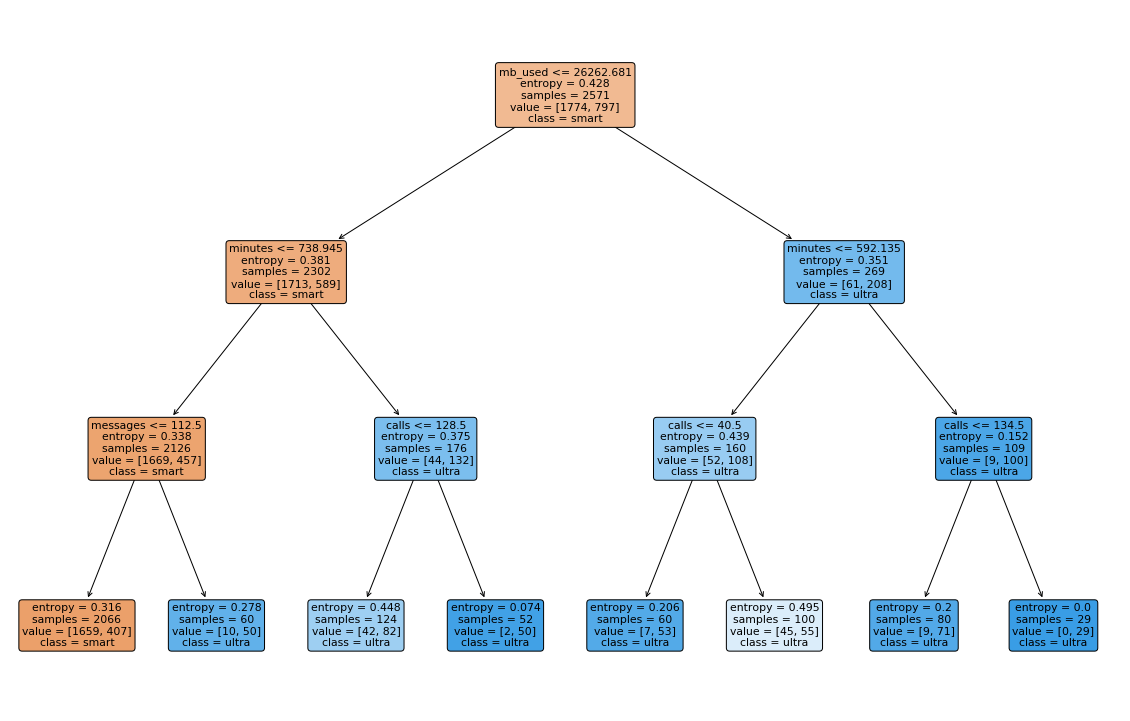

In [20]:
plt.figure(figsize=((20,13)))
plot_tree(model_dec_tree, 
          filled=True, 
          feature_names=features.columns, 
          class_names= ['smart','ultra'], 
          rounded=True)
plt.show()

Интерпретация почему дерево решений оказалось таким эффективным сводится к тому, что мы имеем небольшой объем признаков (4),наиболее сильным влиянием которые обладают 3 из них. 
По результатам проекта анализа тарифов ключевыми статьями использования пакетов и тарификации по ним являются:
 
 - Количество минут;
 
 - Объем потребляемого интернет трафика
 
 - Количество сообщений
 

## 5. (бонус) Проверьте модели на адекватность

In [21]:
import numpy as np

#создаем случайный массив и считаем метрики
predictions_random = pd.Series(np.random.randint(0, 2, len(target_test)), index=target_test.index)

# Проверяем массивы на соответствие размеров:
print(f'Размер исходных целевых характеристик - {len(target_test)}\n\
Размер созданного массива случайных - {len(predictions_random)}')

Размер исходных целевых характеристик - 643
Размер созданного массива случайных - 643


In [22]:
accuracy_rand = accuracy_score(predictions_random, target_test)

print(f'При случайных значениях ответов Accuracy : {accuracy_rand:.2f}')

При случайных значениях ответов Accuracy : 0.49


**В ходе данного тестирования мы получили, что применение машинного обучение может улучшить показатели классификации почти на 10%**

## Вывод

Таким образом, мы:

1) Рассмотрели 4 модели машинного обучения

2) Оценили их эффективность с помощью кроссвалидации прогона параметров по сетке

3) Отобрали 3 модели (градиентный бустинг, случайный лес, дерево решений)

3) Оценили затраты времени на обучение каждой из моделей машинного обучения

4) Оценили их эффективность 

5) Рассмотрели на примере дерева решений вклад признаков и выделили 3 из них, которые повлияли на эффективность данного алгоритма

6) Оценили адекватность. Выигрыш - 10% по accuracy


***В связи с этим, мы предлагаем рассмотреть применение классификатора дерева решений для формирования персональных предложений о переходе на новые тарифы для клиентов оператора в связи с его простотой и эффективностью, показанной на тестах. Более того, он является простым в реализации, что сократит затраты компании для внедрения данной системы***